# Adversarial Attacks

In [6]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from PIL import Image
import json
np.set_printoptions(precision=3,suppress=True)

model = keras.applications.VGG16(weights='imagenet',include_top=True)
classes = json.loads(open('imagenet_classes.json','r').read())

# Optimization for result

## Optimization for result

- To visualize the ideal cat, we start with a random noise image, and try to use gradient descent to adjust the image to make a network recognize it as a cat.

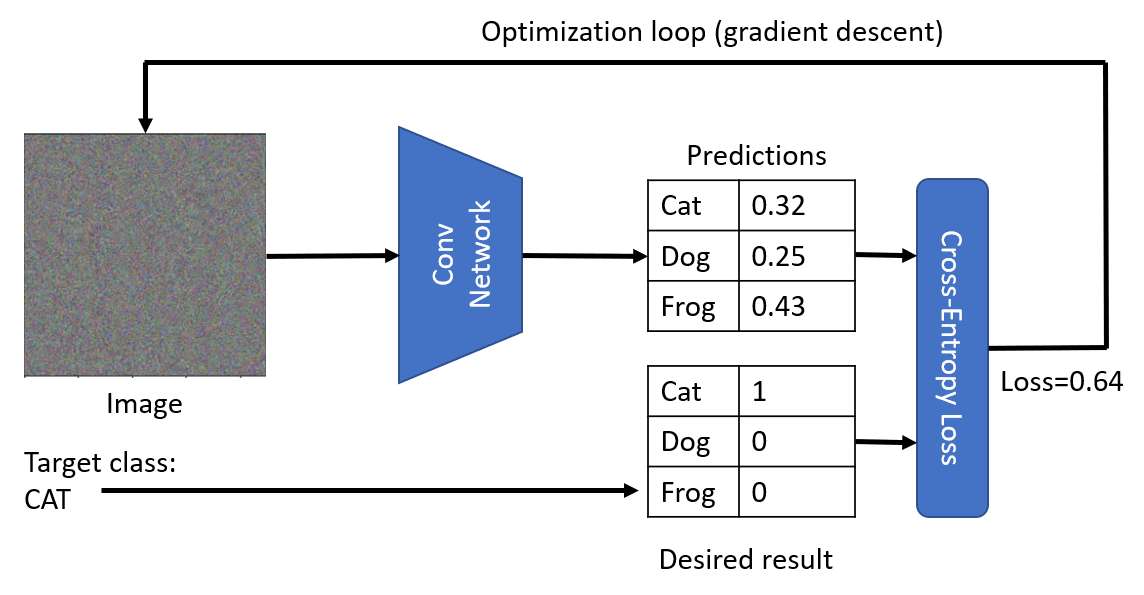

We start from a random noise image:

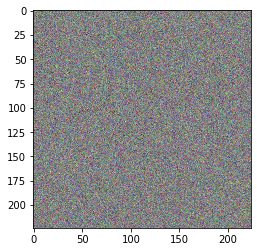

In [7]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))
plt.imshow(normalize(x[0]))

We normalize to bring our values into 0-1 range.

If we call our VGG network on this image, we will get more or less random distribution of probabilities:

Predicted class: 669 (mosquito net)
Probability of predicted class = 0.05126131698489189


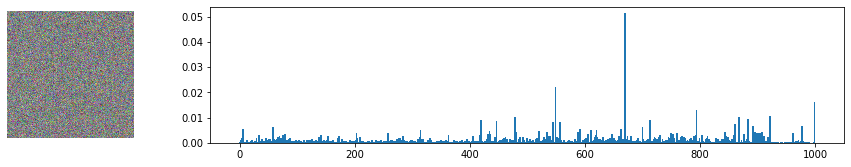

In [8]:
def plot_result(x):
    res = model(x)[0]
    cls = tf.argmax(res)
    print(f"Predicted class: {cls} ({classes[cls]})")
    print(f"Probability of predicted class = {res[cls]}")
    fig,ax = plt.subplots(1,2,figsize=(15,2.5),gridspec_kw = { "width_ratios" : [1,5]} )
    ax[0].imshow(normalize(x[0]))
    ax[0].axis('off')
    ax[1].bar(range(1000),res,width=3)
    plt.show()
plot_result(x)

- Let's choose one target category (e.g., siamese cat), and start adjusting the image using gradient descent. 
- If $x$ is the input image, and $V$ is the VGG network, we calculate the loss function $\mathcal{L}=\mathcal{L}(c,V(x))$ (where $c$ is the target category).

- We adjust $x$ using the following formula:
\begin{equation*}
x^{(i+1)}=x^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial x}
\end{equation*}

- We will use `cross-entropy loss` because we are comparing two probability distributions in a classification problem.

We use `sparese categorical cross-entropy` because the class is represented by a number (and not by one-hot encoded vector).

Epoch: 900, loss: 0.5362939238548279


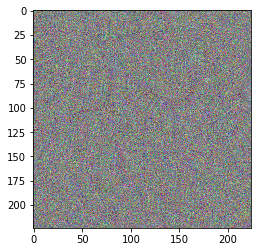

In [9]:
target = [284] # Siamese cat
def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))
def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads)
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()
optimize(x,target)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.6406771540641785


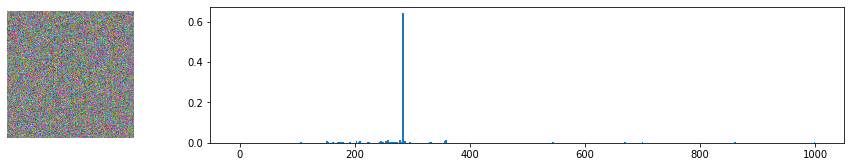

In [10]:
plot_result(x)

- We have obtained an image that looks like a cat for a neural network, even though it looks like a noise for us.
- If we continue to optimize, we would get the image of **ideal noisy cat**, which has probability close to 1.

# Making Sense of Noise

## Making Sense of Noise

- There are many ways to optimize input for the ideal result, the optimization algorithm is not motivated to find patterns that are visually comprehensible.

- To make this look less like a noise, we can introduce an additional term to the loss function - **variation loss**. It measures how similar neighboring pixels of the image are.

- If we add this term to our loss function, it will force the optimizer to find solutions with less noise, and thus having more recognizable details. 

## Making Sense of Noise

- In practice, we need to balance between cross-entropy loss and variation loss to obtain good results.
- We use some coefficients to balance between the losses.

Epoch: 900, loss: [27.241]


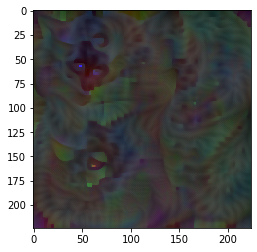

In [12]:
def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.005*tf.image.total_variation(x,res)

optimize(x,target,loss_fn=total_loss)

## Making Sense of Noise

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.9129793643951416


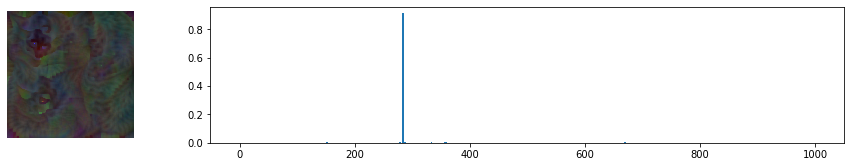

In [13]:
plot_result(x)

- We can observe some familiar features (e.g., eyes and ears). There are many of them, which makes neural network even more certain that this is a cat.

We can try another target class.

Epoch: 900, loss: [29.632]


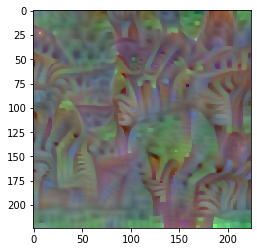

In [14]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,[340],loss_fn=total_loss) # zebra

# Adversarial Attacks

## Adversarial Attacks

- We can see that a very noisy image can be classified as a cat.
- Maybe we can tweak any image in a little way so that it changes its class.

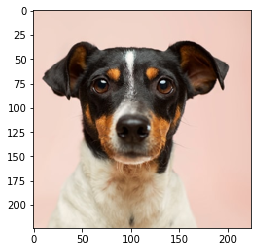

In [15]:
img = Image.open('images/dog-from-unsplash.jpg')
img = img.crop((200,20,600,420)).resize((224,224))
img = np.array(img)
plt.imshow(img)

Predicted class: 171 (Italian greyhound)
Probability of predicted class = 0.9281905293464661


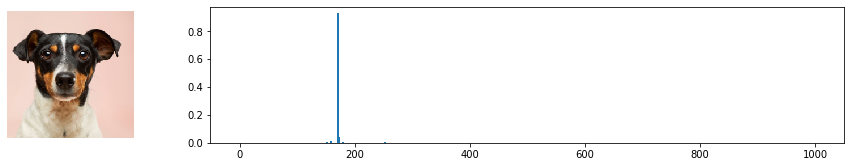

In [16]:
plot_result(np.expand_dims(img,axis=0))

Now, we use this image as a starting point, and try to optimize it to become a cat.

Epoch: 90, loss: 0.15756455063819885


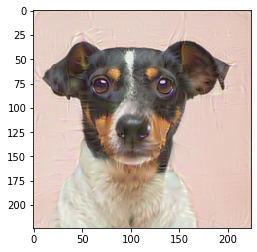

In [17]:
x = tf.Variable(np.expand_dims(img,axis=0).astype(np.float32)/255.0)
optimize(x,target,epochs=100)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.8650807738304138


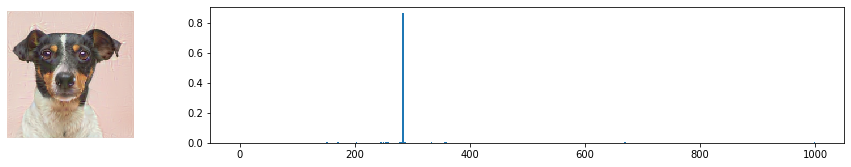

In [18]:
plot_result(x)

The image above is a perfect cat, from the point of view of VGG network!

## Experimenting with ResNet

Let's see how this image is classified by ResNet:

In [19]:
model = keras.applications.ResNet50(weights='imagenet',include_top=True)

102981632/102967424 [==============================] - 9s 0us/step


Predicted class: 111 (nematode, nematode worm, roundworm)
Probability of predicted class = 0.1309644728899002


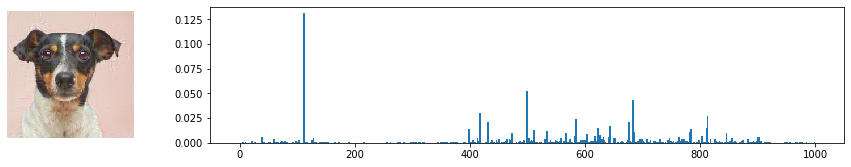

In [20]:
plot_result(x)

- The result is different.
- Because when optimizing for a cat we took into account the nature of VGG network, it's low-level filters, etc. Since ResNet has different filters, it gives different results.

### Example: Ideal zerbra for ResNet

Epoch: 450, loss: [43.233]


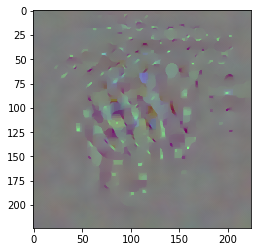

In [25]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,target=[340],epochs=500,loss_fn=total_loss)

Predicted class: 340 (zebra)
Probability of predicted class = 0.8924325704574585


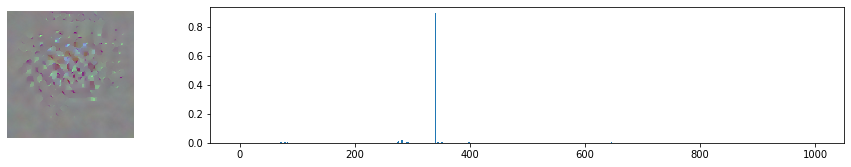

In [22]:
plot_result(x)

- The picture is different from the case of VGG network. The architecture of a neural network plays quite an important role in the way it recognizes objects.

### Using different optimizers

We can try different built-in optimizers from `Keras`

Epoch: 900, loss: [40.634]


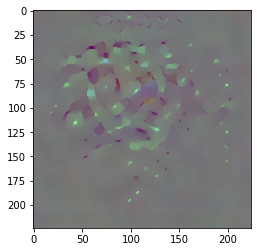

In [23]:
def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss,optimizer=keras.optimizers.SGD(learning_rate=1)):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            optimizer.apply_gradients([(grads,x)])
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

x = tf.Variable(tf.random.normal((1,224,224,3)))

optimize(x,[898],loss_fn=total_loss) # water bottle

## Summary

- We are able to  visualize the ideal image of a cat (as well as any other objects) within pre-trained CNN, using gradient descent to adjust the input image instead of weights

- To get images that make some sense, we use variation loss as an additional loss function, enforcing the images to look smoother.